<a href="https://colab.research.google.com/github/Shahriar88/python_learning/blob/main/python_tutorial_P2_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Python Tutorial – Part 2

## ✅ Topics Covered

* **Efficient workload chunking** for large datasets
* **Thread-based parallelism (with chunks)** using `ThreadPoolExecutor`
* **Vectorized computation in chunks** with NumPy
* **Numba JIT acceleration in chunks**:

  * Using `@njit(parallel=True)` with `prange`
  * Handling very large arrays by splitting into batches
* **CUDA acceleration with Numba**:

  * `@cuda.jit` kernels for elementwise operations
  * Choosing `threads_per_block` and `blocks_per_grid`
  * Chunk-based GPU processing for large arrays
  * Optimized CUDA kernel with tuned block sizes
* **Device information utilities**:

  * `print_cpu_info()` → CPU core/thread details
  * `print_cuda_info()` → GPU details (name, SMs, warp size, max threads/block)
* **Performance comparison across approaches**:

  * Numba (CPU, chunked)
  * CUDA (basic & optimized, chunked)
  * ThreadPoolExecutor (chunked)
  * Pure NumPy vectorization (chunked)

## 🛠️ Implemented Functions

* **`run_numba_chunked()`** → Numba JIT computation in chunks
* **`run_cuda_chunked()`** → CUDA kernel execution in chunks
* **`pick_chunk_size()`** → Automatically tune GPU chunk size
* **`fill_eqn_threaded_chunked()`** → Thread-based parallel processing with chunks
* **`fill_eqn_vectorized_chunked()`** → NumPy vectorized chunked computation
* **`print_cpu_info()` / `print_cuda_info()`** → Hardware inspection helpers

## ⚡ Key Concepts Practiced

* **Chunking strategy** to process massive arrays without exhausting memory
* **CPU vs GPU tradeoffs**: when GPU wins, when CPU (NumPy) is more efficient
* **Threads vs vectorization vs GPU kernels** performance insights
* **CUDA architecture basics**:

  * Streaming Multiprocessors (SMs)
  * Warp size
  * Threads per block tuning
* **Correctness validation** → Comparing results across all approaches with `np.allclose`

## 📂 Files

* **`python_tutorial_P2_V0.ipynb`** → Jupyter Notebook export
* **`python_tutorial_P2_V0.html`** → HTML export of tutorial session

## numba module basics for future use

In [ ]:
# numba module basics for future use ________________________________________
import os
import numpy as np
from functools import wraps
from time import perf_counter
from concurrent.futures import ThreadPoolExecutor

from numba import njit, prange, set_num_threads, get_num_threads
from numba import cuda
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- timing decorator ----------
def timed(label: str | None = None):
    def deco(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            t0 = perf_counter()
            try:
                return func(*args, **kwargs)
            finally:
                dt = perf_counter() - t0
                print(f"[{label or func.__name__}] {dt:.3f} s")
        return wrapper
    return deco
#////////////////////////////////////////////////////////////////////////////////////////////////////
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- Sample data maker for testing code ----------
# --- update the equations, as your requirements *************************
def make_data(N=100, seed=42,
              x_range=(-10, 10), y_range=(-10, 10),
              m_range=(-5, 5),  b_range=(-5, 5),
              dtype=np.float64) -> np.ndarray:
    rng = np.random.default_rng(seed)
    data = np.empty((N, 5), dtype=dtype)
    data[:, 0] = rng.uniform(*x_range, N)  # x
    data[:, 1] = rng.uniform(*y_range, N)  # y
    data[:, 2] = rng.uniform(*m_range, N)  # m
    data[:, 3] = rng.uniform(*b_range, N)  # b
    data[:, 4] = 0.0                       # eqn
    return data
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- Numba CPU kernel equation----------
# --- update the equations *************************
@njit(parallel=True, fastmath=True)
def fill_eqn_numba(data, res_col_idx=4):
    x = data[:, 0]
    y = data[:, 1]
    m = data[:, 2]
    b = data[:, 3]
    out = data[:, res_col_idx]
    n = x.shape[0]
    for i in prange(n):
        x2 = x[i] * x[i]; x4 = x2 * x2
        b3 = b[i] * b[i] * b[i]
        y2 = y[i] * y[i]; y4 = y2 * y2; y8 = y4 * y4; y10 = y8 * y2
        out[i] = y10 + m[i] * x4 + b3


# ---------- chunked Numba (CPU) ----------
@timed("numba_chunked")
def run_numba_chunked(data, res_col_idx=4, chunk_size=5_000_000, threads=None, func = fill_eqn_numba):
    """
    Calls the same @njit(parallel=True) kernel on row-slices of `data`.
    Good when temporaries/cache become the bottleneck on huge arrays.
    """
    if threads:
        set_num_threads(threads)
    N = data.shape[0]
    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)
        # Row slices are C-contiguous → zero-copy views
        func(data[start:end, :], res_col_idx)
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- Numba CUDA kernel ----------
# --- update the equations *************************
# Works with float32 or float64; float32 is faster on most GPUs.
@cuda.jit(fastmath=True)
def fill_eqn_cuda(x, y, m, b, out):
    i = cuda.grid(1)
    if i < x.size:
        xi = x[i]; yi = y[i]; mi = m[i]; bi = b[i]
        x2 = xi * xi; x4 = x2 * x2
        b3 = bi * bi * bi
        y2 = yi * yi; y4 = y2 * y2; y8 = y4 * y4; y10 = y8 * y2
        out[i] = y10 + mi * x4 + b3

# ---------- chunked Numba (GPU) ----------
@timed("cuda_chunked")
def run_cuda_chunked(data, res_col_idx=4, threads_per_block=256, chunk_size=5_000_000, use_float32=False,
                    func=fill_eqn_cuda):
    dtype = np.float32 if use_float32 else np.float64
    N = data.shape[0]
    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)

        # slice host arrays and make them contiguous for the GPU
        x_h = np.ascontiguousarray(data[start:end, 0], dtype=dtype)
        y_h = np.ascontiguousarray(data[start:end, 1], dtype=dtype)
        m_h = np.ascontiguousarray(data[start:end, 2], dtype=dtype)
        b_h = np.ascontiguousarray(data[start:end, 3], dtype=dtype)


        d_x = cuda.to_device(x_h)
        d_y = cuda.to_device(y_h)
        d_m = cuda.to_device(m_h)
        d_b = cuda.to_device(b_h)
        d_out = cuda.device_array(end - start, dtype=dtype)
        blocks = ((end - start) + threads_per_block - 1) // threads_per_block
        func[blocks, threads_per_block](d_x, d_y, d_m, d_b, d_out)
        data[start:end, res_col_idx] = d_out.copy_to_host().astype(data.dtype, copy=False)
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- chunked python_ThreadPoolExecutor (GPU) ----------

# Your existing block function (kept here for completeness)
# --- update the equations *************************
def compute_eqn_block(block_xy_mb: np.ndarray) -> np.ndarray:
    """
    block_xy_mb: (k, 4) array with columns [x, y, m, b]
    returns: (k,) array of y + m*x + b
    """
    x = block_xy_mb[:, 0]
    y = block_xy_mb[:, 1]
    m = block_xy_mb[:, 2]
    b = block_xy_mb[:, 3]
    return y + m * x + b

@timed("python_ThreadPoolExecutor_chunked")
def fill_eqn_threaded_chunked(data: np.ndarray,
                              res_col_idx: int = 4,
                              func=compute_eqn_block,
                              max_workers: int = 4,
                              chunk_size: int = 5_000_000) -> None:
    """
    Processes data in chunks to reduce memory pressure, each chunk is threaded internally.
    """
    N = data.shape[0]
    workers = min(max_workers, os.cpu_count() or 1)

    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)
        chunk = data[start:end, :]  # slice view, no copy

        # Split this chunk among workers
        idx_chunks = np.array_split(np.arange(chunk.shape[0]), workers)

        def job(idxs):
            block = chunk[idxs, :res_col_idx]  # only x,y,m,b
            return func(block)

        with ThreadPoolExecutor(max_workers=workers) as ex:
            futures = [(idxs, ex.submit(job, idxs)) for idxs in idx_chunks if idxs.size > 0]
            for idxs, fut in futures:
                chunk[idxs, res_col_idx] = fut.result()

        # Writes directly into `data[start:end, res_col_idx]` since `chunk` is a view
#////////////////////////////////////////////////////////////////////////////////////////////////////
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# Get CPU and GPU info __________________________
def print_cpu_info():

    import os
    import platform

    try:
        import psutil
    except ImportError:
        psutil = None

    print("CPU Name:", platform.processor() or platform.machine())
    print("Architecture:", platform.architecture()[0])
    print("Logical CPUs:", os.cpu_count())

    if psutil:
        print("Physical cores:", psutil.cpu_count(logical=False))
        print("Max frequency (MHz):", psutil.cpu_freq().max if psutil.cpu_freq() else "N/A")
        print("Current frequency (MHz):", psutil.cpu_freq().current if psutil.cpu_freq() else "N/A")
        print("Total RAM (GB):", round(psutil.virtual_memory().total / (1024**3), 2))
        print(f'get_num_threads_cpu: {get_num_threads()}')
        print('_'*25)
    else:
        print("Install psutil for more details (pip install psutil)")
        print('_'*25)


def print_cuda_info():
    dev = cuda.get_current_device()
    print("Name:", dev.name)
    print("SMs:", dev.MULTIPROCESSOR_COUNT)
    print("Warp size:", dev.WARP_SIZE)
    print("Max threads/block:", dev.MAX_THREADS_PER_BLOCK)
    print('_'*25)

def pick_chunk_size(use_float32=False, safety=0.8):
    free, _ = cuda.current_context().get_memory_info()
    dtype_size = 4 if use_float32 else 8
    per_elem = 5 * dtype_size
    chunk_size = max(1, int(safety * free // per_elem))
    print(f'chunk_size : {chunk_size}')
    print('_'*25)
    return chunk_size
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# ---------- chunked vectorized ----------
# --- update the equations *************************
@timed("vectorized_chunked")
def fill_eqn_vectorized_chunked(data, res_col_idx=4, chunk_size=5_000_000):
    """
    Vectorized per-chunk to limit temporary array sizes.
    """
    N = data.shape[0]
    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)
        x = data[start:end, 0]
        y = data[start:end, 1]
        m = data[start:end, 2]
        b = data[start:end, 3]
        data[start:end, res_col_idx] = y**10 + m*(x**4) + b**3
#////////////////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

# --- Execution *************************

data_nb = make_data(N=300_000_000, seed=123, dtype=np.float64)
data_nb_cuda = data_nb.copy()
data_nb_cuda_opt = data_nb.copy()
data_thread = data_nb.copy()
data_vec = data_nb.copy()

# Numba (CPU) in chunks ___________________________________________________________________
print_cpu_info()
#run_numba_chunked(data_nb, res_col_idx=4, chunk_size=5_000_000, threads=os.cpu_count())
run_numba_chunked(data_nb, res_col_idx=4, chunk_size=5_000_000, threads=4)
#///////////////////////////////////////////////////////////////////////////////////////////

# Fits big N by processing in batches on the GPU _________________________________________________
run_cuda_chunked(data_nb_cuda, res_col_idx=4, threads_per_block=256,
                 chunk_size=5_000_000,   # tune this (see below)
                 use_float32=False)      # True = faster & less memory, slight numeric diffs

#______________CUDA Optimized____________________
print_cuda_info()
chunk_size = pick_chunk_size()
run_cuda_chunked(data_nb_cuda_opt, res_col_idx=4, threads_per_block=512,
                 chunk_size=chunk_size,   # tuned this
                 use_float32=False)      # True = faster & less memory, slight numeric diffs
#///////////////////////////////////////////////////////////////////////////////////////////

# python_ThreadPoolExecutor in chunks ___________________________________________________________________
fill_eqn_threaded_chunked(data_thread, max_workers=4, chunk_size=5_000_000)
#///////////////////////////////////////////////////////////////////////////////////////////

# Vectorized in chunks ___________________________________________________________________
fill_eqn_vectorized_chunked(data_vec, res_col_idx=4, chunk_size=5_000_000)
#///////////////////////////////////////////////////////////////////////////////////////////

#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

print("Equal (Numba vs vectorized, float64)?", np.allclose(data_nb[:, 4], data_vec[:, 4]))
print("Equal (Numba_GPU vs vectorized, float64)?", np.allclose(data_nb_cuda[:, 4], data_vec[:, 4]))
print("Equal (Numba_GPU_Opt vs vectorized, float64)?", np.allclose(data_nb_cuda_opt[:, 4], data_vec[:, 4]))
print("Equal (python_ThreadPoolExecutor vs vectorized, float64)?", np.allclose(data_thread[:, 4], data_vec[:, 4]))

CPU Name: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Architecture: 64bit
Logical CPUs: 16
Physical cores: 8
Max frequency (MHz): 2611.0
Current frequency (MHz): 2611.0
Total RAM (GB): 63.2
get_num_threads_cpu: 16
_________________________
[numba_chunked] 2.108 s
[cuda_chunked] 23.815 s
Name: b'NVIDIA RTX A4000 Laptop GPU'
SMs: 40
Warp size: 32
Max threads/block: 1024
_________________________
chunk_size : 146716753
_________________________
[cuda_chunked] 28.060 s
[python_ThreadPoolExecutor_chunked] 18.340 s
[vectorized_chunked] 43.635 s
Equal (Numba vs vectorized, float64)? True
Equal (Numba_GPU vs vectorized, float64)? True
Equal (Numba_GPU_Opt vs vectorized, float64)? True
Equal (python_ThreadPoolExecutor vs vectorized, float64)? False


## Using Class

In [ ]:
# ----------------- imports (module level) -----------------
import os
import platform
import numpy as np
from time import perf_counter
from functools import wraps
from concurrent.futures import ThreadPoolExecutor
from typing import Optional, Callable

from numba import njit, prange, set_num_threads, get_num_threads
from numba import cuda

# ----------------- timing decorator (module level) -----------------
def timed(label: str | None = None):
    def deco(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            t0 = perf_counter()
            try:
                return func(*args, **kwargs)
            finally:
                dt = perf_counter() - t0
                print(f"[{label or func.__name__}] {dt:.3f} s")
        return wrapper
    return deco

# ----------------- JIT kernels (module level) -----------------
@njit(parallel=True, fastmath=True)
def fill_eqn_numba_kernel(data, res_col_idx=4):
    x = data[:, 0]
    y = data[:, 1]
    m = data[:, 2]
    b = data[:, 3]
    out = data[:, res_col_idx]
    n = x.shape[0]
    for i in prange(n):
        x2 = x[i] * x[i]; x4 = x2 * x2
        b3 = b[i] * b[i] * b[i]
        y2 = y[i] * y[i]; y4 = y2 * y2; y8 = y4 * y4; y10 = y8 * y2
        out[i] = y10 + m[i] * x4 + b3

@cuda.jit(fastmath=True)
def fill_eqn_cuda_kernel(x, y, m, b, out):
    i = cuda.grid(1)
    if i < x.size:
        xi = x[i]; yi = y[i]; mi = m[i]; bi = b[i]
        x2 = xi * xi; x4 = x2 * x2
        b3 = bi * bi * bi
        y2 = yi * yi; y4 = y2 * y2; y8 = y4 * y4; y10 = y8 * y2
        out[i] = y10 + mi * x4 + b3

# Plain Python block function (used by ThreadPoolExecutor path)
def compute_eqn_block(block_xy_mb: np.ndarray) -> np.ndarray:
    x = block_xy_mb[:, 0]
    y = block_xy_mb[:, 1]
    m = block_xy_mb[:, 2]
    b = block_xy_mb[:, 3]
    return y + m * x + b

# Make the threaded function use the same polynomial equation:
def compute_eqn_block_poly(block_xy_mb: np.ndarray) -> np.ndarray:
    x = block_xy_mb[:, 0]
    y = block_xy_mb[:, 1]
    m = block_xy_mb[:, 2]
    b = block_xy_mb[:, 3]
    return y**10 + m * (x**4) + b**3

# ----------------- class that orchestrates -----------------
class ParallelTools:
    # ========= sample data =========
    @staticmethod
    def make_data(N=100, seed=42,
                  x_range=(-10, 10), y_range=(-10, 10),
                  m_range=(-5, 5), b_range=(-5, 5),
                  dtype=np.float64) -> np.ndarray:
        rng = np.random.default_rng(seed)
        data = np.empty((N, 5), dtype=dtype)
        data[:, 0] = rng.uniform(*x_range, N)
        data[:, 1] = rng.uniform(*y_range, N)
        data[:, 2] = rng.uniform(*m_range, N)
        data[:, 3] = rng.uniform(*b_range, N)
        data[:, 4] = 0.0
        return data

    # ========= numba CPU (chunked) =========
    @staticmethod
    @timed("numba_chunked")
    def run_numba_chunked(data: np.ndarray,
                          res_col_idx: int = 4,
                          chunk_size: int = 5_000_000,
                          threads: Optional[int] = None,
                          func: Optional[Callable] = None):
        if threads:
            set_num_threads(threads)
        if func is None:
            func = fill_eqn_numba_kernel

        N = data.shape[0]
        for start in range(0, N, chunk_size):
            end = min(start + chunk_size, N)
            func(data[start:end, :], res_col_idx)

    # ========= CUDA (chunked) =========
    @staticmethod
    @timed("cuda_chunked")
    def run_cuda_chunked(data: np.ndarray,
                         res_col_idx: int = 4,
                         threads_per_block: int = 256,
                         chunk_size: int = 5_000_000,
                         use_float32: bool = False,
                         func = fill_eqn_cuda_kernel):
        dtype = np.float32 if use_float32 else np.float64
        N = data.shape[0]
        for start in range(0, N, chunk_size):
            end = min(start + chunk_size, N)

            # prepare contiguous host buffers
            x_h = np.ascontiguousarray(data[start:end, 0], dtype=dtype)
            y_h = np.ascontiguousarray(data[start:end, 1], dtype=dtype)
            m_h = np.ascontiguousarray(data[start:end, 2], dtype=dtype)
            b_h = np.ascontiguousarray(data[start:end, 3], dtype=dtype)

            # device copies
            d_x = cuda.to_device(x_h)
            d_y = cuda.to_device(y_h)
            d_m = cuda.to_device(m_h)
            d_b = cuda.to_device(b_h)
            d_out = cuda.device_array(end - start, dtype=dtype)

            blocks = ((end - start) + threads_per_block - 1) // threads_per_block
            func[blocks, threads_per_block](d_x, d_y, d_m, d_b, d_out)

            data[start:end, res_col_idx] = d_out.copy_to_host().astype(data.dtype, copy=False)

    # ========= Python threads (chunked) =========
    @staticmethod
    @timed("python_ThreadPoolExecutor_chunked")
    def fill_eqn_threaded_chunked(data: np.ndarray,
                                  res_col_idx: int = 4,
                                  func: Optional[Callable] = None,
                                  max_workers: int = 4,
                                  chunk_size: int = 5_000_000):
        if func is None:
            func = compute_eqn_block

        N = data.shape[0]
        workers = min(max_workers, os.cpu_count() or 1)

        for start in range(0, N, chunk_size):
            end = min(start + chunk_size, N)
            chunk = data[start:end, :]  # view

            idx_chunks = np.array_split(np.arange(chunk.shape[0]), workers)

            def job(idxs):
                block = chunk[idxs, :res_col_idx]
                return func(block)

            with ThreadPoolExecutor(max_workers=workers) as ex:
                futures = [(idxs, ex.submit(job, idxs)) for idxs in idx_chunks if idxs.size > 0]
                for idxs, fut in futures:
                    chunk[idxs, res_col_idx] = fut.result()

    # ========= vectorized (chunked) =========
    @staticmethod
    @timed("vectorized_chunked")
    def fill_eqn_vectorized_chunked(data: np.ndarray, res_col_idx: int = 4, chunk_size: int = 5_000_000):
        N = data.shape[0]
        for start in range(0, N, chunk_size):
            end = min(start + chunk_size, N)
            x = data[start:end, 0]
            y = data[start:end, 1]
            m = data[start:end, 2]
            b = data[start:end, 3]
            data[start:end, res_col_idx] = y**10 + m*(x**4) + b**3

    # ========= system info =========
    @staticmethod
    def print_cpu_info():
        try:
            import psutil
        except ImportError:
            psutil = None

        print("CPU Name:", platform.processor() or platform.machine())
        print("Architecture:", platform.architecture()[0])
        print("Logical CPUs:", os.cpu_count())
        if psutil:
            print("Physical cores:", psutil.cpu_count(logical=False))
            f = psutil.cpu_freq()
            print("Max frequency (MHz):", f.max if f else "N/A")
            print("Current frequency (MHz):", f.current if f else "N/A")
            print("Total RAM (GB):", round(psutil.virtual_memory().total / (1024**3), 2))
        print("Numba threads (current):", get_num_threads())
        print("_"*25)

    @staticmethod
    def print_cuda_info():
        dev = cuda.get_current_device()
        print("Name:", dev.name)
        print("SMs:", dev.MULTIPROCESSOR_COUNT)
        print("Warp size:", dev.WARP_SIZE)
        print("Max threads/block:", dev.MAX_THREADS_PER_BLOCK)
        print("_"*25)

    @staticmethod
    def pick_chunk_size(use_float32=False, safety=0.8):
        free, _ = cuda.current_context().get_memory_info()
        dtype_size = 4 if use_float32 else 8
        per_elem = 5 * dtype_size  # x,y,m,b,out
        chunk_size = max(1, int(safety * free // per_elem))
        print("chunk_size:", chunk_size)
        print("_"*25)
        return chunk_size



# ---------- Sample data maker for testing code ----------
# --- update the equations, as your requirements *************************
def make_data(N=100, seed=42,
              x_range=(-10, 10), y_range=(-10, 10),
              m_range=(-5, 5),  b_range=(-5, 5),
              dtype=np.float64) -> np.ndarray:
    rng = np.random.default_rng(seed)
    data = np.empty((N, 5), dtype=dtype)
    data[:, 0] = rng.uniform(*x_range, N)  # x
    data[:, 1] = rng.uniform(*y_range, N)  # y
    data[:, 2] = rng.uniform(*m_range, N)  # m
    data[:, 3] = rng.uniform(*b_range, N)  # b
    data[:, 4] = 0.0                       # eqn
    return data
#////////////////////////////////////////////////////////////////////////////////////////////////////

# Base once
base = make_data(N=30_000_000, seed=123, dtype=np.float64)

# (Optional) tiny warmup to avoid counting JIT compile time in first timing
ParallelTools.run_numba_chunked(base[:100_000].copy(), chunk_size=50_000, threads=4)

# CPU Numba
data_nb = base.copy()
ParallelTools.run_numba_chunked(data_nb, res_col_idx=4, chunk_size=5_000_000, threads=4)

# Vectorized
data_vec = base.copy()
ParallelTools.fill_eqn_vectorized_chunked(data_vec, res_col_idx=4, chunk_size=5_000_000)
print("Equal (Numba vs vectorized)?", np.allclose(data_nb[:,4], data_vec[:,4]))

# CUDA (256)
data_gpu = base.copy()
ParallelTools.run_cuda_chunked(data_gpu, res_col_idx=4, threads_per_block=256,
                               chunk_size=5_000_000, use_float32=False)
print("Equal (GPU vs vectorized)?", np.allclose(data_gpu[:,4], data_vec[:,4]))

# CUDA tuned chunk size (ensure context exists before pick_chunk_size)
ParallelTools.print_cuda_info()
cs = ParallelTools.pick_chunk_size(use_float32=False)   # or True for speed (then relax tolerances)
data_gpu_opt = base.copy()
ParallelTools.run_cuda_chunked(data_gpu_opt, res_col_idx=4, threads_per_block=512,
                               chunk_size=cs, use_float32=False)
print("Equal (GPU_opt vs vectorized)?", np.allclose(data_gpu_opt[:,4], data_vec[:,4]))

# ThreadPool
data_thr = base.copy()
ParallelTools.fill_eqn_threaded_chunked(
    data_thr,
    res_col_idx=4,
    func=compute_eqn_block_poly,   # <-- use the same formula
    max_workers=4,
    chunk_size=5_000_000
)
print("Equal (ThreadPool vs vectorized)?", np.allclose(data_thr[:,4], data_vec[:,4]))



[numba_chunked] 0.455 s
[numba_chunked] 0.074 s
[vectorized_chunked] 2.479 s
Equal (Numba vs vectorized)? True
[cuda_chunked] 1.336 s
Equal (GPU vs vectorized)? True
Name: b'NVIDIA RTX A4000 Laptop GPU'
SMs: 40
Warp size: 32
Max threads/block: 1024
_________________________
chunk_size: 147555614
_________________________
[cuda_chunked] 0.639 s
Equal (GPU_opt vs vectorized)? True
[python_ThreadPoolExecutor_chunked] 0.899 s
Equal (ThreadPool vs vectorized)? True


# Example: timing methods in a class

In [ ]:
import time
from functools import wraps
from time import perf_counter

# your same decorator
def timed(label: str | None = None):
    def deco(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            t0 = perf_counter()
            try:
                return func(*args, **kwargs)
            finally:
                dt = perf_counter() - t0
                print(f"[{label or func.__name__}] {dt:.3f} s")
        return wrapper
    return deco

# ----------------------
# Using inside a class
# ----------------------
class Worker:
    def __init__(self, name):
        self.name = name

    @timed("instance_method") # instance: self
    def do_work(self, n=2.5):
        time.sleep(n)  # simulate work
        return f"{self.name} finished in {n} sec"

    @classmethod # classmethod: cls
    @timed("class_method")
    def do_classwork(cls, n=2.5):
        time.sleep(n)
        return f"classwork finished in {n} sec"

    @staticmethod # staticmethod: None
    @timed("static_method")
    def do_staticwork(n=2.5):
        time.sleep(n)
        return f"staticwork finished in {n} sec"

# ----------------------
# Run
# ----------------------
w = Worker("Alice")
print(w.do_work(3.5))
print(Worker.do_classwork(3.5))
print(Worker.do_staticwork(3.5))


[instance_method] 3.500 s
Alice finished in 3.5 sec
[class_method] 3.501 s
classwork finished in 3.5 sec
[static_method] 3.501 s
staticwork finished in 3.5 sec


In [ ]:
class Celsius:
    def __init__(self, temperature=0):
        self._temperature = temperature

    @property #getter
    def temperature(self):
        return self._temperature

    @temperature.setter
    def temperature(self, value):
        if value < -273.15:
            raise ValueError("Temperature below -273.15 is not possible")
        self._temperature = value

## 1️⃣ Instance Methods (default, no decorator)

- Defined normally inside a class.  
- First argument is always **`self`**, which refers to the instance of the class.  
- Used when you need access to **instance attributes**.

In [ ]:
class Dog:
    def __init__(self, name):
        self.name = name

    def bark(self):  # instance method
        return f"{self.name} says woof!"

d = Dog("Rex")
print(d.bark())   # Rex says woof!


Rex says woof!


## 2️⃣ Class Methods (`@classmethod`)

- Declared with **`@classmethod`**.  
- First argument is always **`cls`** (the class itself, not an instance).  
- Often used for **alternative constructors** or **operations that affect the whole class**, not just one instance.

In [ ]:
class Dog:
    species = "Canis familiaris"

    def __init__(self, name):
        self.name = name

    @classmethod
    def set_species(cls, species_name):
        cls.species = species_name

d1 = Dog("Buddy")
d2 = Dog("Max")

print(d1.species)   # Canis familiaris
Dog.set_species("Canis lupus familiaris")  # change at class level
print(d2.species)   # Canis lupus familiaris


Canis familiaris
Canis lupus familiaris


## 3️⃣ Static Methods (`@staticmethod`)

- Declared with **`@staticmethod`**.  
- Behaves like a plain function placed inside the **class namespace**.  
- No `self`, no `cls` is automatically passed.  
- Useful for **utility/helper functions** logically related to the class.

In [ ]:
class MathTools:
    @staticmethod
    def add(a, b):
        return a + b

    @staticmethod
    def is_even(n):
        return n % 2 == 0

print(MathTools.add(3, 4))     # 7
print(MathTools.is_even(10))   # True


7
True


## 4️⃣ Special Methods (dunder methods like `__str__`, `__len__`, etc.)

- Names start and end with **double underscores** (`__`).  
- Define how objects behave with **built-in Python operations**.  
- Examples:  
  - `__str__` → string representation (`str(obj)`)  
  - `__len__` → length of object (`len(obj)`)  
  - `__add__` → addition (`obj1 + obj2`)

In [ ]:
class Book:
    def __init__(self, title, pages):
        self.title = title
        self.pages = pages

    def __str__(self):
        return f"Book: {self.title}"

    def __len__(self):
        return self.pages

b = Book("Python Guide", 500)
print(b)         # Book: Python Guide   (uses __str__)
print(len(b))    # 500                  (uses __len__)


Book: Python Guide
500


In [ ]:
class MathTools:
    @staticmethod
    def add(a, b):
        return a + b

    @staticmethod
    def is_even(n):
        return n % 2 == 0

    @staticmethod
    def add_is_even(a, b):
        c = MathTools.add(a, b)   # call via class
        return MathTools.is_even(c)

print(MathTools.add(3, 4))        # 7
print(MathTools.is_even(10))      # True
print(MathTools.add_is_even(6, 4))  # True
print(MathTools.add_is_even(5, 4))  # False


7
True
True
False


## 🔑 Key Point

- `@staticmethod`s don’t get **self** or **cls**, so they can’t call other methods without explicitly qualifying them.  
- If you want them to easily call each other, consider using **class methods** instead.

---

## 🔎 Why?

- In a **normal method** (no decorator), Python automatically passes the **instance** (`self`) as the first argument.  
- In a **`@classmethod`**, Python automatically passes the **class** (`cls`) as the first argument.  
- In a **`@staticmethod`**, Python passes **nothing automatically** — you only get what you explicitly put in the argument list.  

👉 So `cls` only works because of the `@classmethod` decorator.  
Without it, `cls` is just a regular parameter name (like `x`, `y`, or `foo`) and won’t receive the class reference.

---

### Example
```python
class Demo:
    def normal(self):
        print("self is:", self)

    @classmethod
    def class_method(cls):
        print("cls is:", cls)

    @staticmethod
    def static_method(x):
        print("got:", x)

# Usage
obj = Demo()
obj.normal()           # self is: <__main__.Demo object>
Demo.class_method()    # cls is: <class '__main__.Demo'>
Demo.static_method(10) # got: 10


In [ ]:
class MathTools:
    @classmethod
    def add(cls, a, b):
        return a + b

    @classmethod
    def is_even(cls, n):
        return n % 2 == 0

    @classmethod
    def add_is_even(cls, a, b):
        c = cls.add(a, b)      # cleaner call
        return cls.is_even(c)

print(MathTools.add_is_even(5, 4))  # False


False


**import re ** loads Python’s regular expressions module. It’s in the standard library (no install needed) and lets you search, match, split, and replace text using patterns.

Why use it?

Validate strings (emails, dates, IDs)

Find or extract substrings

Do powerful find-and-replace

Text cleanup and parsing

In [ ]:
import re

# 1) Search
m = re.search(r"\bcat\b", "the cat sat")
print(bool(m))               # True

# 2) Find all matches
nums = re.findall(r"\d+", "a12 b003 c9")
print(nums)                  # ['12', '003', '9']

# 3) Replace
clean = re.sub(r"\s+", " ", "too   many\nspaces")
print(clean)                 # "too many spaces"

# 4) Split by multiple separators
parts = re.split(r"[;,]\s*", "a, b; c")
print(parts)                 # ['a', 'b', 'c']

# 5) Precompile a pattern (faster if reused)
pat = re.compile(r"(\w+)=(\d+)")
print(pat.findall("x=1 y=22"))  # [('x', '1'), ('y', '22')]


True
['12', '003', '9']
too many spaces
['a', 'b', 'c']
[('x', '1'), ('y', '22')]


# Matplotlib

### Sine & Cosine Waves with Styling

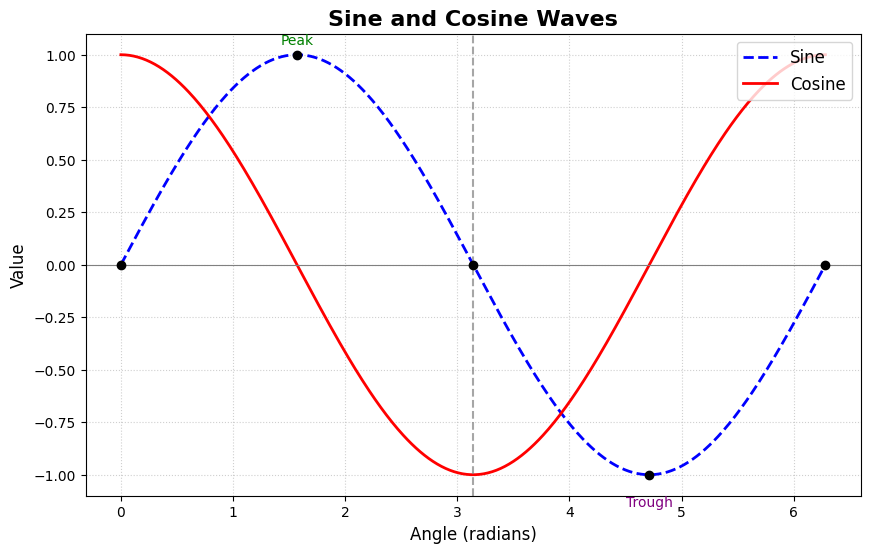

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Data
x = np.linspace(0, 2*np.pi, 500)
y1 = np.sin(x)
y2 = np.cos(x)

# 2. Create figure
plt.figure(figsize=(10,6))

# 3. Plot sine and cosine
plt.plot(x, y1, label="Sine", color="blue", linewidth=2, linestyle="--")
plt.plot(x, y2, label="Cosine", color="red", linewidth=2)

# 4. Add titles and labels
plt.title("Sine and Cosine Waves", fontsize=16, fontweight="bold")
plt.xlabel("Angle (radians)", fontsize=12)
plt.ylabel("Value", fontsize=12)

# 5. Highlight interesting points
plt.scatter([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
            [0, 1, 0, -1, 0],
            color="black", zorder=5)
plt.text(np.pi/2, 1.05, "Peak", ha="center", fontsize=10, color="green")
plt.text(3*np.pi/2, -1.15, "Trough", ha="center", fontsize=10, color="purple")

# 6. Customize grid & legend
plt.grid(True, linestyle=":", alpha=0.6)
plt.axhline(0, color="gray", linewidth=0.8)  # x-axis line
plt.axvline(np.pi, color="gray", linestyle="--", alpha=0.7)  # mark π

plt.legend(fontsize=12, loc="upper right")

# 7. Show
plt.show()


# End